In [ ]:
from valurap import gcode, asg, path_planning as pp
import logging
import pandas as pd
import numpy as np
import numpy
import matplotlib.pyplot as plt
import IPython
import time
from IPython.display import display
import os
import pickle
from pprint import pprint

import imp
imp.reload(pp)
imp.reload(gcode)
imp.reload(asg)

fn = "esk_handle"
lines = gcode.reader(fn + ".gcode")
pg = gcode.path_gen(lines)
sg = gcode.gen_segments(pg)

sk = 25

for i, s in enumerate(sg):
    if isinstance(s, gcode.do_move):
        print(i, s)
    elif isinstance(s, gcode.do_ext):
        print(i, s)
    elif isinstance(s, gcode.do_home):
        print(i, s)
    elif isinstance(s, gcode.do_segment):
        print("segment", i, len(s.path))
        sk -= 1
        if sk == 0:
            break
    else:
        assert (False)
        
print("start")
pprint(s.path[0])
pprint(s.path[1])
pprint(s.path[2])
last_k = len(s.path) - 1
print("end")
pprint(s.path[last_k - 2])
pprint(s.path[last_k - 1])
pprint(s.path[last_k])


In [ ]:
from math import sqrt, ceil, hypot
from valurap.asg import ProfileSegment
from valurap.emulate import emulate

import valurap.path_planning2 as pp2
imp.reload(pp2)

if 1:
    gcode_path = s.path
else:
    gcode_path = [
        #    X      Y     F    E  Line
        (  0.00,  0.00,   0,   0.0,    1),
        (  0.00,  1.00, 100,   0.0,    2),
        (  1.00,  1.00, 100,   0.0,    3),
        (  1.00,  2.00, 100,   1.0,    4),
        ( 10.00, 10.00, 100,  11.0,    5),
        ( 10.00, 15.00, 100,  15.0,    6),
        ( 10.00, 15.00,   0,   0.0,    7),
    ]

class LP(pp2.PathPlanner):
    pass

planner = LP()
planner.max_seg = 10.0
planner.emu_in_loop = True

t0 = time.time()
path, slowdowns = planner.make_path(gcode_path, 1.0)
display(path)


recheck = False
# process slowdowns to match max corner error
print("!!!!! corners pass !!!!!!")
slowdowns, updated, cc = planner.process_corner_errors(path, slowdowns)
if recheck:
    print("!!!!! corners pass 2 !!!!!!")
    slowdowns, updated, cc = planner.process_corner_errors(path, slowdowns)
    #display(cc)
    #display(path)



print("!!!!! reverse pass !!!!!!")
slowdowns, updated = planner.reverse_pass(path, slowdowns)
if recheck:
    print("!!!!! reverse pass 2 !!!!!!")
    slowdowns, updated = planner.reverse_pass(path, slowdowns)
print("!!!!! forward pass !!!!!!")
slowdowns, updated = planner.forward_pass(path, slowdowns)
if recheck:
    print("!!!!! forward pass 2 !!!!!!")
    slowdowns, updated = planner.forward_pass(path, slowdowns)
    print("!!!!! reverse pass 3 !!!!!!")
    slowdowns, updated = planner.reverse_pass(path, slowdowns)
    print("!!!!! forward pass 3 !!!!!!")
    slowdowns, updated = planner.forward_pass(path, slowdowns)
    print("!!!!! reverse pass 4 !!!!!!")
    slowdowns, updated = planner.reverse_pass(path, slowdowns)
    print("!!!!! forward pass 4 !!!!!!")
    slowdowns, updated = planner.forward_pass(path, slowdowns)
    print("=====")

t1 = time.time()
print("time:", t1 - t0)
if 0:
    speeds = planner.gen_speeds(path, slowdowns)
    cc_slowdowns, updated, cc = planner.process_corner_errors(path, slowdowns)

    display(path)
    display(speeds)
    display(cc)
    #display(slowdowns[slowdowns["corner"]<1])

segments, profile = planner.gen_segments_float(path, slowdowns)
display(segments)
display(profile)
#segments = planner.gen_segments(path, slowdowns, add_reset = False)


In [ ]:
df = segments.copy()
df["evx1"] = df["vx0"] + df["ax"] * df["dt"] - df["vx1"]
df["evy1"] = df["vy0"] + df["ay"] * df["dt"] - df["vy1"]
df["ex1"] = df["x0"] + df["vx0"] * df["dt"] + df["ax"] * df["dt"] * df["dt"] / 2 - df["x1"]
df["ey1"] = df["y0"] + df["vy0"] * df["dt"] + df["ay"] * df["dt"] * df["dt"] / 2 - df["y1"]
display(df[df["x1"] != (df["x0"].shift(-1))])
display(df[df["y1"] != (df["y0"].shift(-1))])
display(df[df["vx1"] != (df["vx0"].shift(-1))])
display(df[df["vy1"] != (df["vy0"].shift(-1))])

display(df[np.abs(df["evx1"])>0.01])
display(df[np.abs(df["evy1"])>0.01])
display(df[np.abs(df["ex1"])>0.01])
display(df[np.abs(df["ey1"])>0.01])

In [ ]:
%matplotlib notebook

it = 0
step = 0.001
t = it * step
data = []

for i, row in segments.iterrows():
    end_t = row["t"] + row["dt"]
    while t < end_t:
        t = it * step
        lt = t - row["t"]
        x = row["x0"] + row["vx0"] * lt + row["ax"] * lt * lt / 2
        y = row["y0"] + row["vy0"] * lt + row["ay"] * lt * lt / 2
        vx = row["vx0"] + row["ax"] * lt
        vy = row["vy0"] + row["ay"] * lt
        pnt = {"t": t, "i": i, "lt": lt, "x": x, "y": y, "vx": vx, "vy": vy}
        data.append(pnt)
        it += 1
               
    if i>500:
        break
        
sf = 10
df = pd.DataFrame(data)
df["sx"] = df["x"].rolling(sf*2 + 1).mean().shift(-sf)
df["sy"] = df["y"].rolling(sf*2 + 1).mean().shift(-sf)
df["ex"] = df["sx"] - df["x"]
df["ey"] = df["sy"] - df["y"]

df["dx"] = df["sx"].diff() / step
df["dy"] = df["sy"].diff() / step
df["ddx"] = df["dx"].diff() / step
df["ddy"] = df["dy"].diff() / step
#df.plot(x="t", y=["dx", "dy", "ddx", "ddy"], secondary_y=['ddx', 'ddy'])
#df.plot(x="sx", y="sy", style=None)
df.plot(x="t", y=["ex", "ey"], secondary_y=[])


In [ ]:
0.14075188017123352/(49.99954310992635 + 49.95134077034891)*2

In [ ]:
%matplotlib notebook
res = emulate(profile, accel_step=planner.accel_step, verbose=0)
res["x"] = res["X_x"] / planner.spm
res["y"] = res["Y_x"] / planner.spm
res["e"] = res["Z_x"] / planner.spme
sf = 5
res["dx"] = res["X_x"].diff().rolling(sf*2 + 1).mean().shift(-sf)
res["dy"] = res["Y_x"].diff().rolling(sf*2 + 1).mean().shift(-sf)
res["de"] = -res["Z_x"].diff().rolling(sf*2 + 1).mean().shift(-sf)
res["xv"] = res["X_v"] * 65536 / planner.k_vxy
res["yv"] = res["Y_v"] * 65536 / planner.k_vxy
res["ev"] = res["Z_v"] * 65536 / planner.k_ve
res["xa"] = res["X_a"] / planner.k_axy
res["ya"] = res["Y_a"] / planner.k_axy
res["ea"] = res["Z_a"] / planner.k_ae
res["v"] = np.linalg.norm([res["xv"], res["yv"]], axis=0)
res["dxy"] = np.linalg.norm([res["dx"], res["dy"]], axis=0)
#display(res[["t", "x", "y", "xv", "yv", "v", "xa", "ya"]])
#res.plot(x="x", y="y", style=None)
res.plot(x="t", y=["dxy", "de"],secondary_y=["de"])


In [ ]:
#res.plot(x="t", y=["xv", "yv", "v", "xa", "ya"], secondary_y=["xa", "ya"])

res.plot(x="t", y=["x", "y", "de"],secondary_y=["de"])
#res.plot(x="x", y="y", style="*")

In [ ]:
s = "   |"

for i in range(1, 20):
    s += " {:3d}".format(i)
    
print(s)
print("-" * len(s))

for i in range(1, 20):
    s = "{:2d} |".format(i)
    for o in range(1, 20):
        s += " {:3d}".format(i*o)
    print(s)

In [ ]:
import imp
import valurap.path_planning2 as pp2
imp.reload(pp2)

planner = pp2.PathPlanner()
planner.max_seg = 10.0
planner.emu_in_loop = True
planner.delta_e_err = 10

planner.gen_layers("esk_blade.gcode")



In [19]:
from valurap import emulate
import pickle
import valurap.asg as vas
import valurap.path_planning2 as pp2

start = None
apg_map = None
apgs = {
    "X": pp2.FakeApg("X"),
    "Y": pp2.FakeApg("Y"),
    "Z": pp2.FakeApg("Z"),
}

base = "esk_blade"
layer = 15

with open("{}_{:05d}.layer".format(base, layer), "rb") as f:
    p = pickle.load(f)
        
spm = 80
assert len(p) == 2
assert p[0][0] == "start"
assert p[1][0] == "segment"
if start is None:
    start = p[0]

pr_opt = [
    [1, [
        vas.ProfileSegment(apgs["X"], x=p[0][1]["X"] * spm),
        vas.ProfileSegment(apgs["Y"], x=p[0][1]["Y"] * spm),
        vas.ProfileSegment(apgs["Z"], x=0),
    ]]
]

cms, meta, segments = p[1]

print(meta)
acc_step = meta["acc_step"]

for dt, segs in segments:
    pr_opt.append([
        dt, [vas.ProfileSegment.from_tuple(s, apgs) for s in segs]
    ])

res = emulate.emulate(pr_opt, accel_step=int(50000000/acc_step))
display(res)

Warning, explicit X in segment
Warning, explicit X in segment
Warning, explicit X in segment
{'map': {'X1': 'X', 'Y': 'Y', 'E1': 'Z'}, 'acc_step': 10000}


,X_a,X_j,X_jj,X_v,X_x,Y_a,Y_j,Y_jj,Y_v,Y_x,Z_a,Z_j,Z_jj,Z_v,Z_x,ts,t
0,0,0,0,0.000000,1052.400000,0,0,0,0.000000,521.280000,0,0,0,0.000000,0.000000,0,0.0000
1,0,0,0,0.000000,1052.400000,0,0,0,0.000000,521.280000,0,0,0,0.000000,0.000000,1,0.0001
2,0,0,0,0.000000,1052.400000,0,0,0,0.000000,521.280000,0,0,0,0.000000,0.000000,2,0.0002
3,0,0,0,0.000000,1052.400000,0,0,0,0.000000,521.280000,0,0,0,0.000000,0.000000,3,0.0003
4,0,0,0,0.000000,1052.400000,0,0,0,0.000000,521.280000,0,0,0,0.000000,0.000000,4,0.0004
5,0,0,0,0.000000,1052.400000,0,0,0,0.000000,521.280000,0,0,0,0.000000,0.000000,5,0.0005
6,-1675661,0,0,0.000000,1052.400000,45030257,0,0,0.000000,521.280000,0,0,0,0.000000,0.000000,6,0.0006
7,-1675661,0,0,-0.000397,1052.400000,45030257,0,0,0.010483,521.280000,0,0,0,0.000000,0.000000,7,0.0007
8,-1675661,0,0,-0.000793,1052.399970,45030257,0,0,0.020966,521.280800,0,0,0,0.000000,0.000000,8,0.0008
9,-1675661,0,0,-0.001190,1052.399909,45030257,0,0,0.031448,521.282399,0,0,0,0.000000,0.000000,9,0.0009


<IPython.core.display.Javascript object>


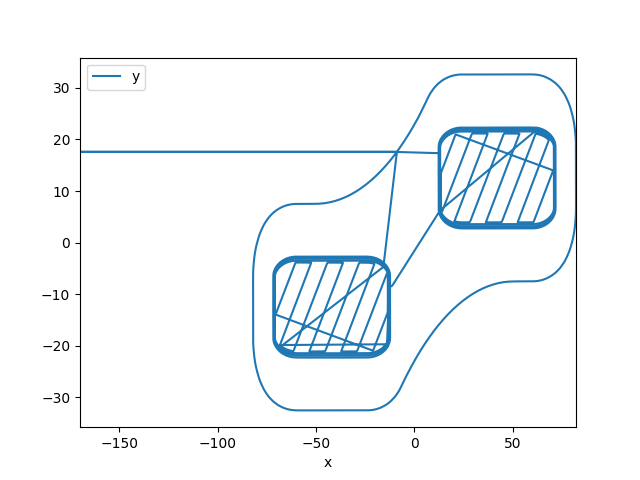

In [20]:
%matplotlib notebook

import numpy as np
planner = pp2.PathPlanner()

res["x"] = res["X_x"] / planner.spm
res["y"] = res["Y_x"] / planner.spm
res["e"] = res["Z_x"] / planner.spme
sf = 5
res["dx"] = res["X_x"].diff().rolling(sf*2 + 1).mean().shift(-sf)
res["dy"] = res["Y_x"].diff().rolling(sf*2 + 1).mean().shift(-sf)
res["de"] = -res["Z_x"].diff().rolling(sf*2 + 1).mean().shift(-sf)
res["xv"] = res["X_v"] * 65536 / planner.k_vxy
res["yv"] = res["Y_v"] * 65536 / planner.k_vxy
res["ev"] = res["Z_v"] * 65536 / planner.k_ve
res["xa"] = res["X_a"] / planner.k_axy
res["ya"] = res["Y_a"] / planner.k_axy
res["ea"] = res["Z_a"] / planner.k_ae
res["v"] = np.linalg.norm([res["xv"], res["yv"]], axis=0)
res["dxy"] = np.linalg.norm([res["dx"], res["dy"]], axis=0)
#display(res[["t", "x", "y", "xv", "yv", "v", "xa", "ya"]])
#res.plot(x="x", y="y", style=None)
#res.plot(x="t", y=["dxy", "de"],secondary_y=["de"])
res.plot(x="x", y="y")

In [ ]:
res.plot(x="t", y=["dxy", "de"],secondary_y=["de"])


In [23]:
from valurap.path_planning2 import PathPlanner
p = PathPlanner()
2**32/p.k_ae

9115.166704002391